In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold 
from sklift.models import SoloModel
from sklift.models import TwoModels
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import statistics
from scipy import stats

In [2]:
def cross_validate(model, X, y, split = 3):
   skf = StratifiedKFold(n_splits=split)
   models = []
   scores = []
   for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        score = accuracy_score(model.predict(X_val), y_val)
        scores.append(score)
        models.append(model)
        print(score)
   print(np.mean(scores), np.std(scores))
   return models

def pred_cross(models, X):
  preds = [mode.predict(X) for mode in models]
  res = []
  for i in range(len(preds[0])):
     pr = [pred[i] for pred in preds]
     res.append(int(stats.mode(pr)[0][0]))
  return res

def pred_proba(models, X):
  res = [model.predict_proba(X) for model in models]
  return np.sum(res, axis=0)

def bootstrap(
    data_column_1, 
    data_column_2, 
    boot_it = 1000, 
    statistic = np.median, 
    bootstrap_conf_level = 0.95 
):
    df_1 = int(len(data_column_1) - 1)
    df_2 = int(len(data_column_2) - 1)
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
      
    p_1 = stats.t.cdf(
        df = df_1,
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.t.cdf(
        df =df_2,
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    plt.vlines(quants,ymin=0,ymax=250,linestyle='--', color = 'blue')
    plt.hist(boot_data)
    plt.xlabel('boot_data', color = 'black')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return min(p_1, p_2) * 2, quants, statistics.mode(boot_data)


In [3]:
data = pd.read_csv('sampled_dataset.csv')

In [4]:
X = data.drop('conversion', axis =1)
y = data['conversion']

In [5]:
data

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,treatment,conversion,visit,exposure
0,24.349239,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1,18.071957,10.059654,8.214383,3.907662,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
2,25.750729,10.059654,8.214383,4.679882,10.280525,4.115453,-8.281971,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3,22.206538,10.059654,8.214383,4.679882,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0
4,12.616365,10.059654,8.389815,4.679882,10.280525,4.115453,0.294443,4.833815,3.906514,20.050937,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160757,20.934049,10.059654,8.874458,4.679882,11.029584,4.115453,-1.288207,4.833815,3.786333,13.190056,6.315688,-0.168679,1,0,0,0
160758,18.259595,10.679513,8.549536,-0.824913,10.280525,3.013064,-10.987528,7.975369,3.867720,32.395545,5.300375,-0.168679,1,0,0,0
160759,21.971762,10.059654,8.856038,4.679882,10.280525,4.115453,-14.005516,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
160760,13.744354,10.059654,8.395875,-0.877095,11.029584,4.115453,-16.505589,4.833815,3.773461,37.868188,6.157435,-0.168679,1,0,1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160762 entries, 0 to 160761
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_0   160762 non-null  float64
 1   feature_1   160762 non-null  float64
 2   feature_2   160762 non-null  float64
 3   feature_3   160762 non-null  float64
 4   feature_4   160762 non-null  float64
 5   feature_5   160762 non-null  float64
 6   feature_6   160762 non-null  float64
 7   feature_7   160762 non-null  float64
 8   feature_8   160762 non-null  float64
 9   feature_9   160762 non-null  float64
 10  feature_10  160762 non-null  float64
 11  feature_11  160762 non-null  float64
 12  treatment   160762 non-null  int64  
 13  conversion  160762 non-null  int64  
 14  visit       160762 non-null  int64  
 15  exposure    160762 non-null  int64  
dtypes: float64(12), int64(4)
memory usage: 19.6 MB


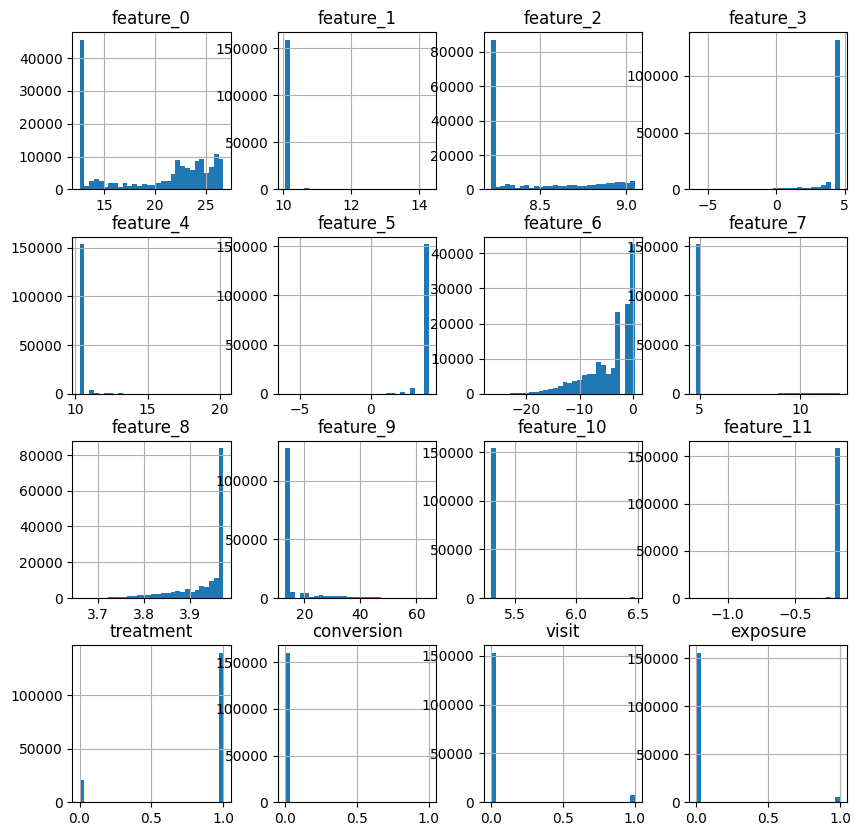

In [7]:
data.select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(10, 10))
plt.show()

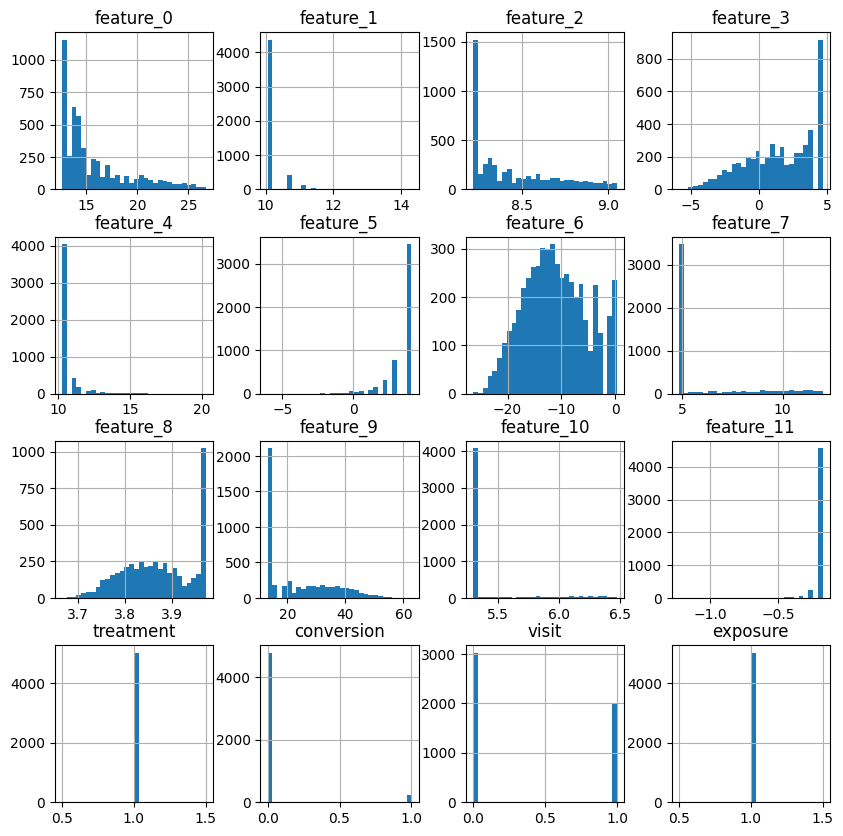

In [8]:
data.query('exposure == 1').select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(10, 10))
plt.show()

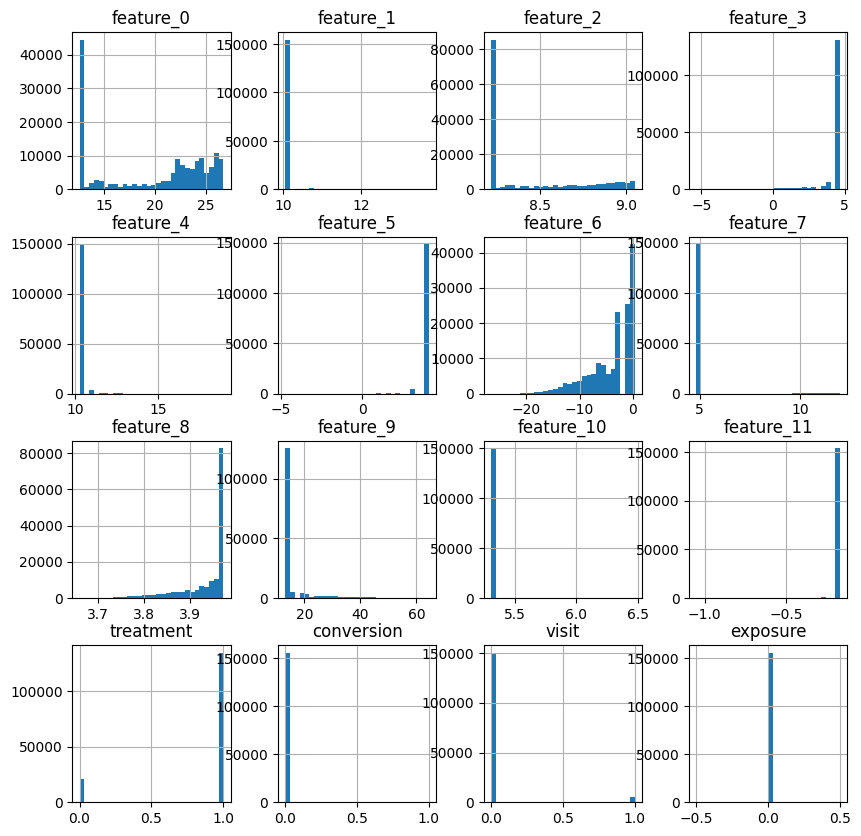

In [9]:
data.query('exposure == 0').select_dtypes(include=['int64', 'float64']).hist(bins=30, figsize=(10, 10))
plt.show()

In [10]:
model = CatBoostClassifier(verbose = 0)
model.fit(X, y)

In [11]:
cat = cross_validate(CatBoostClassifier(verbose = 0), X, y, 5)

0.9970764780891364
0.997356389761453
0.9969830803682508
0.9975429211246579
0.9974807165961682
0.9972879171879333 0.00022114207741604384


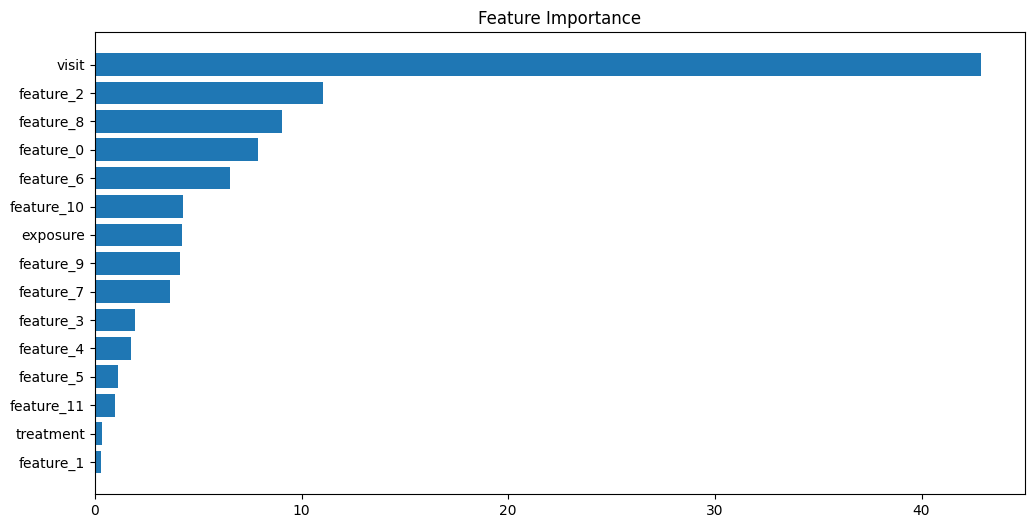

In [12]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

In [13]:
X_cat = X.drop(['feature_1', 'feature_11', 'feature_5', 'feature_4', 'treatment'], axis = 1)

In [14]:
int_col = [x for x in X_cat.columns if X_cat[x].dtype == 'int64']
for name in int_col:
  X_cat[name] = X_cat[name].astype(np.int8)

In [15]:
cat = cross_validate(CatBoostClassifier(verbose = 0), X_cat, y, 5)

0.9972319845737567
0.9971075793860604
0.9969519781040059
0.9972318984822095
0.9971696939537198
0.9971386268999505 0.00010409815204106407


In [16]:
estimator_trmnt = CatBoostClassifier( thread_count=2, verbose = 0, random_state=42)
estimator_ctrl = CatBoostClassifier(thread_count=2, random_state=42, verbose = 0)

# define approach
tm_ctrl = TwoModels(
    estimator_trmnt=estimator_trmnt,
    estimator_ctrl=estimator_ctrl,
    method='ddr_control'
)


tm_ctrl = tm_ctrl.fit(
    X_cat.drop('exposure', axis = 1), y, X_cat['exposure'],
)

In [17]:
test =  tm_ctrl.predict(X_cat.query('exposure == 1'))  
control = tm_ctrl.predict(X_cat.query('exposure == 0'))  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


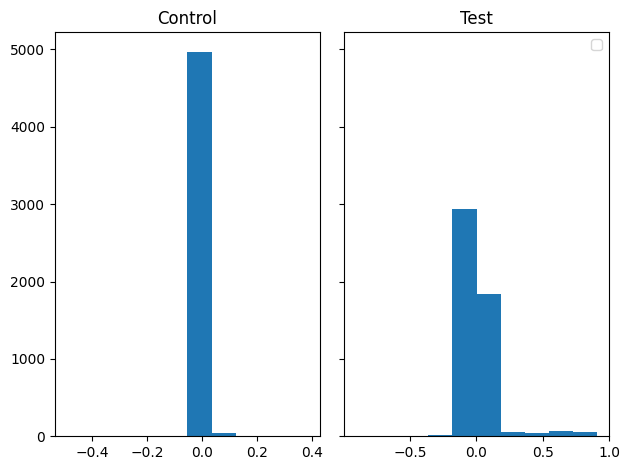

In [18]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(np.random.choice(control, size = len(test)), bins = 10)
axs[1].hist(test, bins = 10)
axs[0].set_title('Control')
axs[1].set_title('Test')
plt.legend()
plt.show()

In [19]:
uplift_test = pd.DataFrame()
uplift_control = pd.DataFrame()

In [20]:
uplift_test['test'] = test
uplift_control['control'] = control

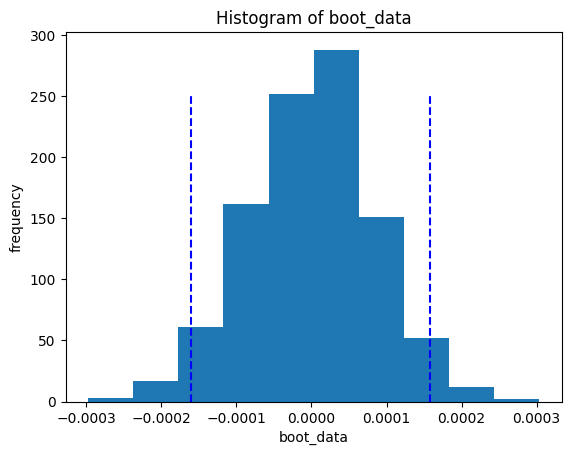

Статистическая значимость 0.99


In [21]:
p_value, _, _ = bootstrap(uplift_control['control'], uplift_control['control'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(p_value,2)))

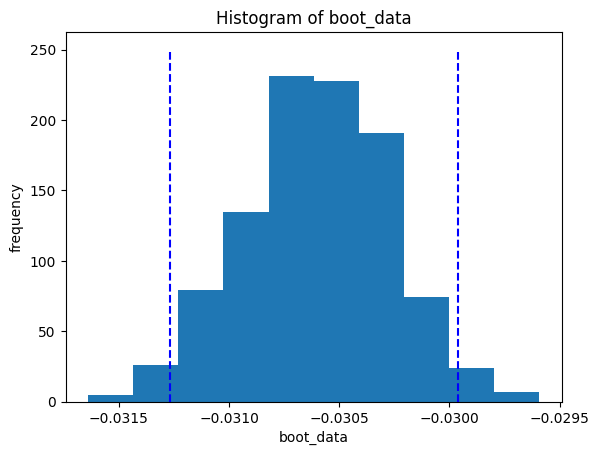

Ошибка второго рода бутстрапа 0.0


In [22]:
p_value, quants, _ = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Ошибка второго рода бутстрапа {}'.format(round(p_value,2)))

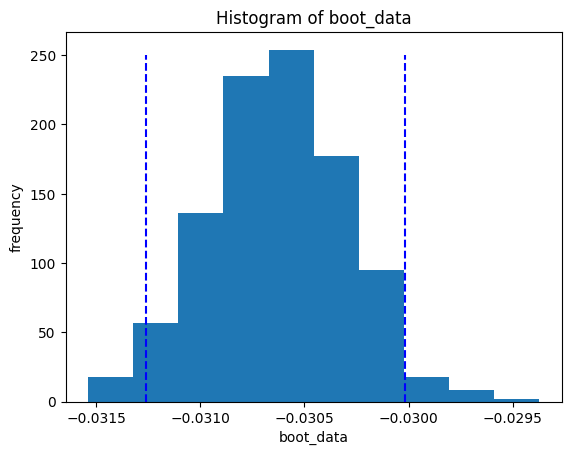

Статистическая значимость 0.0


In [23]:
p_value, quant, mode = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(np.mean(p_value), 3)))

In [24]:
all_ = pd.concat([uplift_control['control'], uplift_test['test']], axis = 0)
std_all = np.std(all_)
n = len(all_)
mde = np.sqrt(0.95 ** 2 * std_all ** 2 / n)

In [25]:
print('Минимальный детектируемый эффект = {}'.format(mde))

Минимальный детектируемый эффект = 7.56408420030634e-05


In [26]:
log = cross_validate(LogisticRegression(max_iter = 1000), X_cat, y, 5)

0.9972941871676049
0.9972941871676049
0.9973252052749441
0.9973252052749441
0.9972941030106992
0.9973065775791594 1.5209480962484122e-05


In [27]:
estimator_trmnt = LogisticRegression(max_iter = 1000)
estimator_ctrl = LogisticRegression(max_iter = 1000)

# define approach
tm_ctrl = TwoModels(
    estimator_trmnt=estimator_trmnt,
    estimator_ctrl=estimator_ctrl,
    method='ddr_control'
)


tm_ctrl = tm_ctrl.fit(
    X_cat.drop('exposure', axis = 1), y, X_cat['exposure'],
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


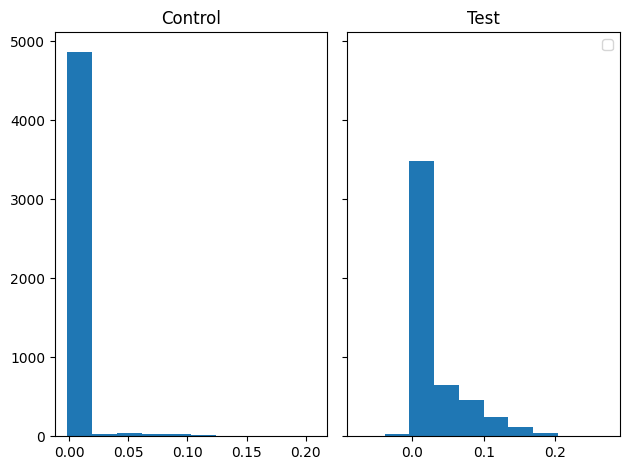

In [29]:
test =  tm_ctrl.predict(X_cat.query('exposure == 1').drop('exposure', axis = 1))  
control = tm_ctrl.predict(X_cat.query('exposure == 0').drop('exposure', axis = 1))  

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(np.random.choice(control, size = len(test)), bins = 10)
axs[1].hist(test, bins = 10)
axs[0].set_title('Control')
axs[1].set_title('Test')
plt.legend()
plt.show()

In [30]:
uplift_test['test'] = test
uplift_control['control'] = control

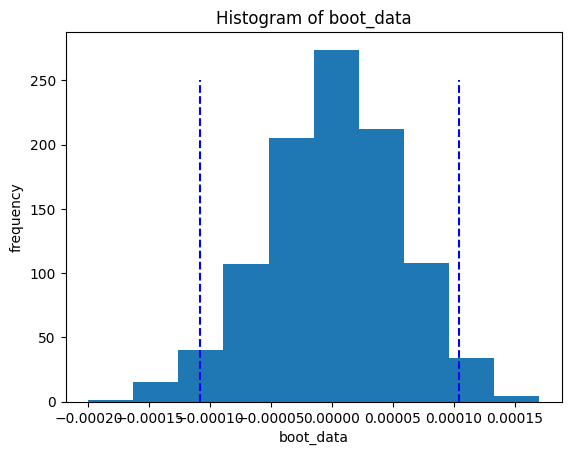

Статистическая значимость 0.99


In [31]:
p_value, _, _ = bootstrap(uplift_control['control'], uplift_control['control'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(p_value,2)))

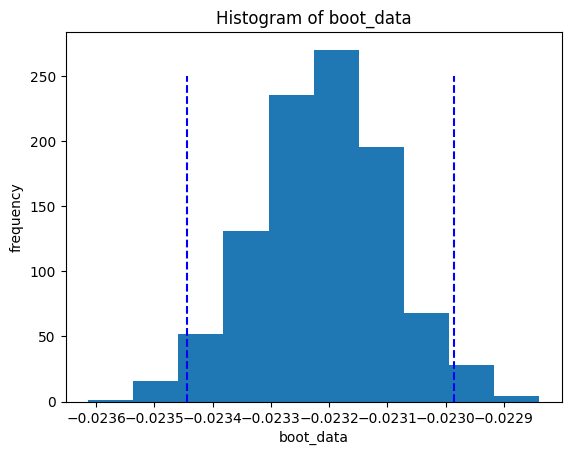

Ошибка второго рода бутстрапа 0.0


In [32]:
p_value, quants, _ = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Ошибка второго рода бутстрапа {}'.format(round(p_value,2)))

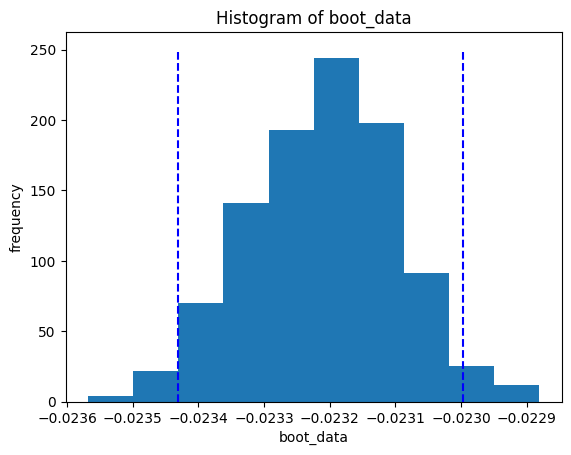

Статистическая значимость 0.0


In [33]:
p_value, quant, mode = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(np.mean(p_value), 3)))

In [34]:
all_ = pd.concat([uplift_control['control'], uplift_test['test']], axis = 0)
std_all = np.std(all_)
n = len(all_)
mde = np.sqrt(0.95 ** 2 * std_all ** 2 / n)

In [35]:
print('Минимальный детектируемый эффект = {}'.format(mde))

Минимальный детектируемый эффект = 3.9967835757353886e-05


In [36]:
sm = SoloModel(CatBoostClassifier(verbose=100, random_state=777))  # define approach
sm = sm.fit(X_cat.drop(['exposure'], axis = 1), y, X_cat['exposure'], estimator_fit_params={'plot': True})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.090152
0:	learn: 0.3407226	total: 12.7ms	remaining: 12.7s
100:	learn: 0.0067564	total: 1.1s	remaining: 9.76s
200:	learn: 0.0059273	total: 2.05s	remaining: 8.14s
300:	learn: 0.0052715	total: 3s	remaining: 6.97s
400:	learn: 0.0047444	total: 4.18s	remaining: 6.25s
500:	learn: 0.0043324	total: 5.23s	remaining: 5.21s
600:	learn: 0.0040006	total: 6.24s	remaining: 4.14s
700:	learn: 0.0036773	total: 7.27s	remaining: 3.1s
800:	learn: 0.0033772	total: 8.35s	remaining: 2.08s
900:	learn: 0.0031158	total: 9.28s	remaining: 1.02s
999:	learn: 0.0028821	total: 10.3s	remaining: 0us


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


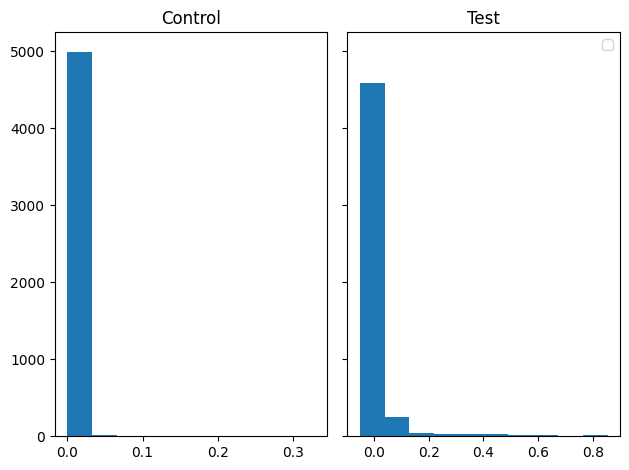

In [37]:
test =  sm.predict(X_cat.query('exposure == 1').drop('exposure', axis = 1))  
control = sm.predict(X_cat.query('exposure == 0').drop('exposure', axis = 1))  

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(np.random.choice(control, size = len(test)), bins = 10)
axs[1].hist(test, bins = 10)
axs[0].set_title('Control')
axs[1].set_title('Test')
plt.legend()
plt.show()

In [38]:
uplift_test['test'] = test
uplift_control['control'] = control

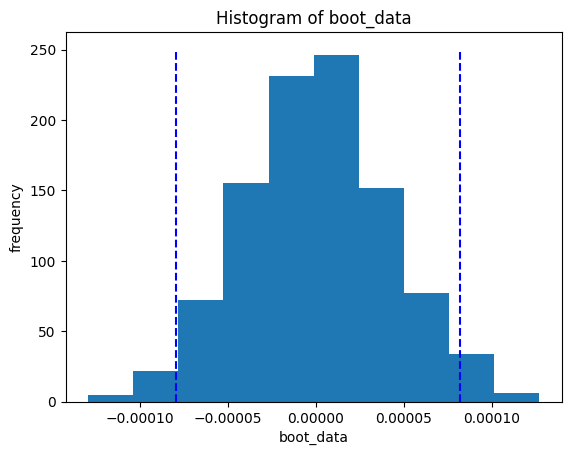

Статистическая значимость 0.99


In [39]:
p_value, _, _ = bootstrap(uplift_control['control'], uplift_control['control'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(p_value,2)))

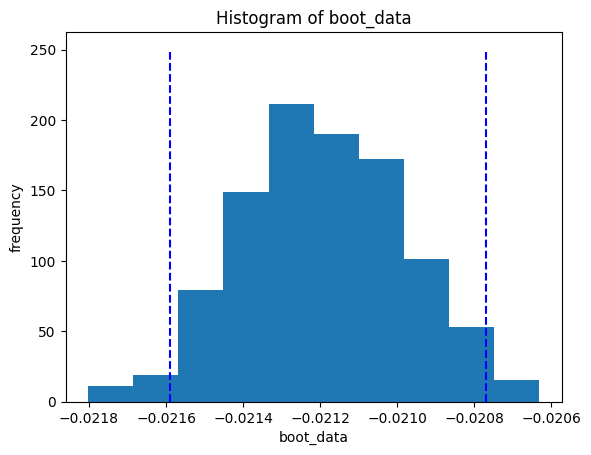

Ошибка второго рода бутстрапа 0.0


In [40]:
p_value, quants, _ = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Ошибка второго рода бутстрапа {}'.format(round(p_value,2)))

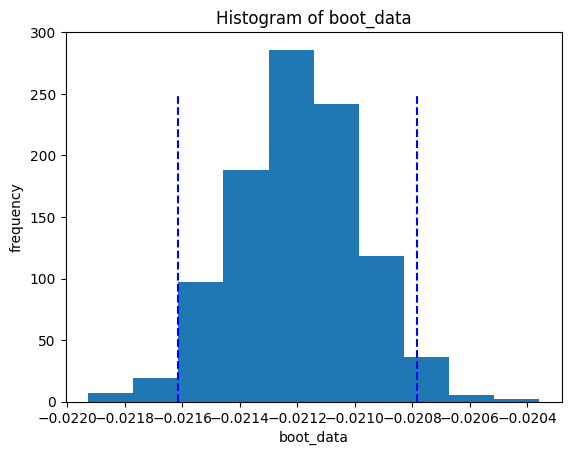

Статистическая значимость 0.0


In [41]:
p_value, quant, mode = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(np.mean(p_value), 3)))

In [44]:
sm = SoloModel(LogisticRegression(max_iter = 1000))  # define approach
sm = sm.fit(X_cat.drop(['exposure'], axis = 1), y, X_cat['exposure'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


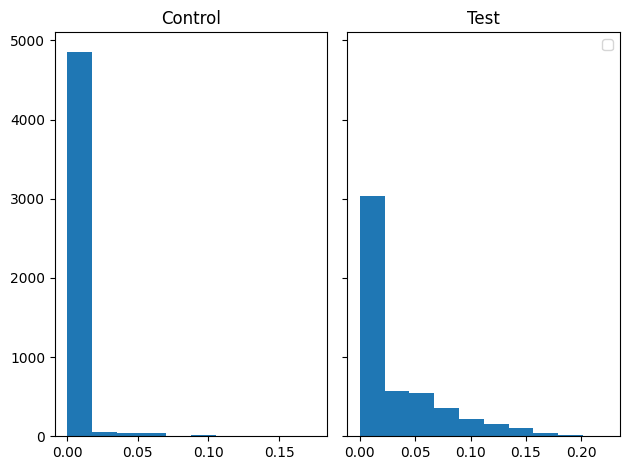

In [45]:
test =  sm.predict(X_cat.query('exposure == 1').drop('exposure', axis = 1))  
control = sm.predict(X_cat.query('exposure == 0').drop('exposure', axis = 1))  

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(np.random.choice(control, size = len(test)), bins = 10)
axs[1].hist(test, bins = 10)
axs[0].set_title('Control')
axs[1].set_title('Test')
plt.legend()
plt.show()

In [46]:
uplift_test['test'] = test
uplift_control['control'] = control

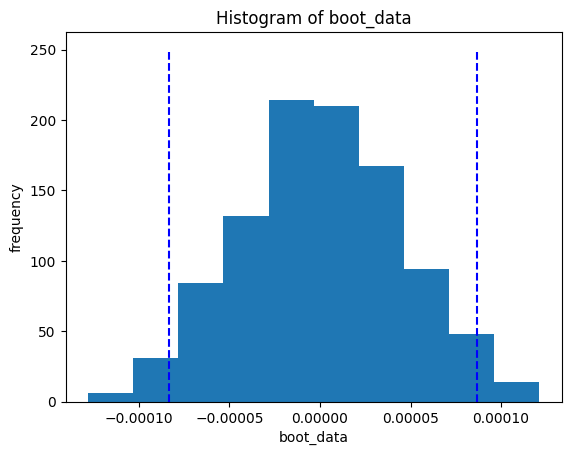

Статистическая значимость 0.99


In [47]:
p_value, _, _ = bootstrap(uplift_control['control'], uplift_control['control'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(p_value,2)))

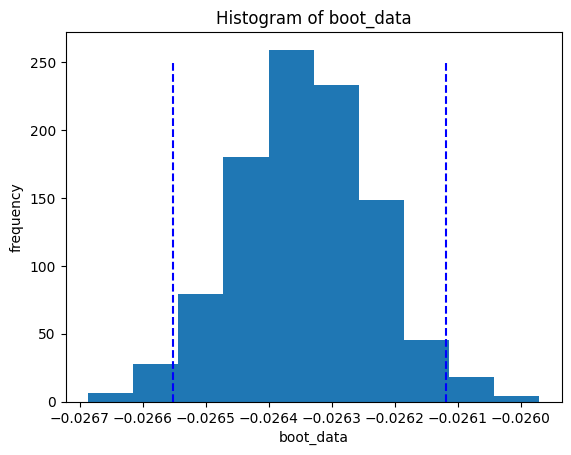

Ошибка второго рода бутстрапа 0.0


In [48]:
p_value, quants, _ = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, 
          bootstrap_conf_level = 0.95)
print('Ошибка второго рода бутстрапа {}'.format(round(p_value,2)))

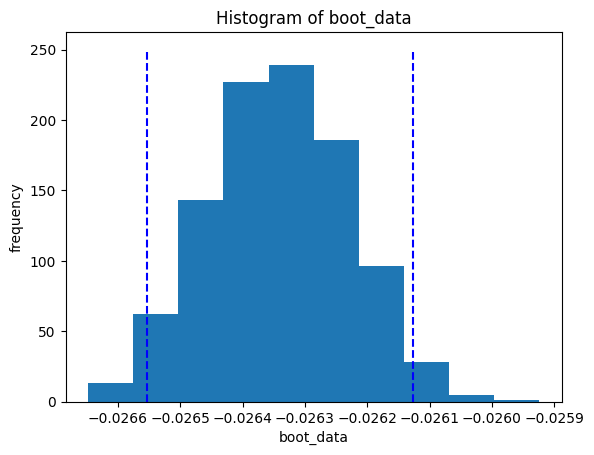

Статистическая значимость 0.0


In [49]:
p_value, quant, mode = bootstrap(uplift_control['control'], uplift_test['test'], boot_it=1000, statistic = np.mean, bootstrap_conf_level = 0.95)
print('Статистическая значимость {}'.format(round(np.mean(p_value), 3)))

In [ ]:
В целом все модели показали прирост конверсии после воздецствия на полльзователя на уровне 2-3%